# Demo: Encoding PSF variation with BLISS

This notebook demonstrates the capability of BLISS to encode and use PSF information to make more accurate predictions compared to a PSF-unaware model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt

from os import environ
from pathlib import Path

import hydra

from bliss.catalog import TileCatalog
from bliss.encoder import Encoder
from bliss.simulator.decoder import ImageDecoder

In [3]:
# set bliss home directory and load config
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose("config")

## Load models and the data

We will compare two models:
1. A "PSF-unaware" model that has been trained on a single PSF (and has no information about the PSF during inference), and
2. A "PSF-aware" model that has been trained on images from different PSFs, and uses both the deconvolved image and the PSF parameters during inference.

In [5]:
# psf-unaware model (trained on single PSF)
base_model: Encoder = hydra.utils.instantiate(
    cfg.encoder,
    input_transform_params={"use_deconv_channel": False, "concat_psf_params": False}
)
base_model.load_state_dict(torch.load(Path(cfg.paths.pretrained_models) / "single_field.pt"))
base_model.eval();

# psf-aware model (trained with varying PSFs)
psf_model: Encoder = hydra.utils.instantiate(cfg.encoder)
psf_model.load_state_dict(torch.load(Path(cfg.paths.pretrained_models) / "psf_aware.pt"));
psf_model.eval();


                 from  n    params  module                                  arguments                     
  0                -1  1      3328  yolov5.models.common.Conv               [2, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

FileNotFoundError: [Errno 2] No such file or directory: '/home/aakashdp/bliss/data/pretrained_models/psf_aware.pt'

In [4]:
# load data
simulator = hydra.utils.instantiate(cfg.cached_simulator)
dataloader = simulator.test_dataloader()
batch = next(iter(dataloader))

The images we will be using are generated from the same catalog, but using different PSFs. Let's plot them to see the differences:

In [75]:
# construct PSF images from saved params
decoder: ImageDecoder = hydra.utils.instantiate(cfg.simulator.decoder)
small_psf = decoder._get_psf(batch["psf_params"][0])
large_psf = decoder._get_psf(batch["psf_params"][1])

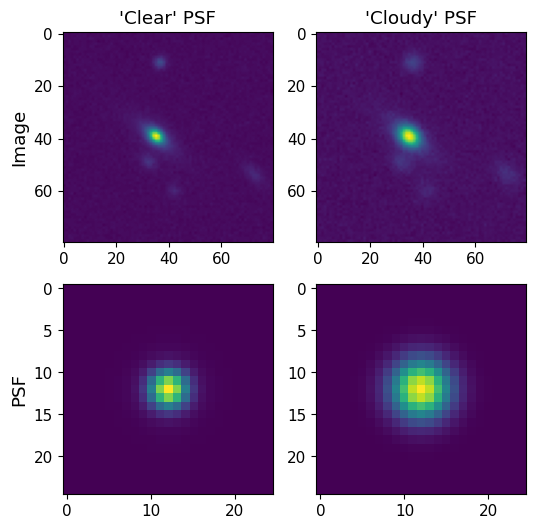

In [76]:
# plot images and PSFs
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].set_title("'Clear' PSF", size="large")
ax[0, 1].set_title("'Cloudy' PSF", size="large")
ax[0, 0].set_ylabel("Image", rotation=90, size="large")
ax[1, 0].set_ylabel("PSF", rotation=90, size="large")

ax[0, 0].imshow(batch["images"][0, 0])
ax[0, 1].imshow(batch["images"][1, 0])

ax[1, 0].imshow(small_psf[0].original.image.array)
ax[1, 1].imshow(large_psf[0].original.image.array)

## Make predictions on both models

In [59]:
# instantiate the Trainer
trainer = hydra.utils.instantiate(cfg.training.trainer, accelerator="cpu", logger=None)

# make predictions
base_results = trainer.predict(base_model, dataloader)
psf_results = trainer.predict(psf_model, dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

## Plot predictions and true locations

In [16]:
# Adjust predicted locations to account for cropped tiles
px_to_crop = base_model.tiles_to_crop * base_model.tile_slen
with torch.inference_mode():
    base_results[0]["est_cat"].plocs += 4
    psf_results[0]["est_cat"].plocs += 4

# get true locations
true_catalog = TileCatalog(cfg.encoder.tile_slen, batch["tile_catalog"]).to_full_params()
true_locs = true_catalog.plocs

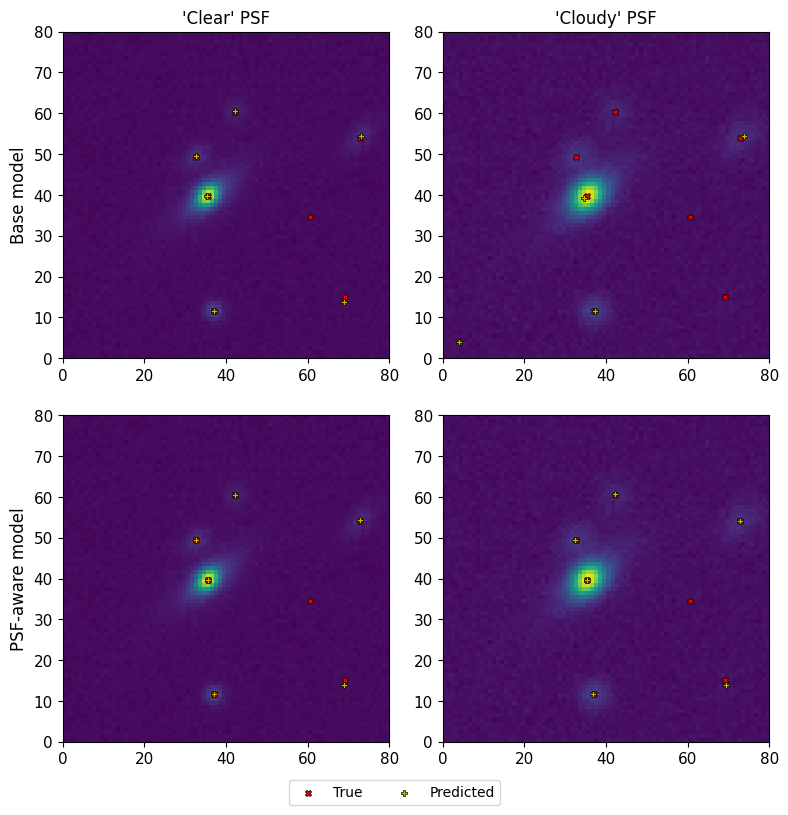

In [58]:
# Plot true and estimated predictions for both models and both images
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

for row in range(2):
    for col in range(2):
        ax[row, col].imshow(batch["images"][col, 0], origin="lower", extent=(0, 80, 0, 80))
        ax[row, col].scatter(true_locs[col, :, 1], true_locs[col, :, 0], color="r", s=20, marker="X", edgecolors="black", linewidth=0.5, label="True")
        est_locs = base_results[0]["est_cat"].plocs if row == 0 else psf_results[0]["est_cat"].plocs
        ax[row, col].scatter(est_locs[col, :, 1], est_locs[col, :, 0], color="y", s=20, marker="P", edgecolors="black", linewidth=0.5, label="Predicted")

# add row and column labels
ax[0, 0].set_ylabel("Base model", rotation=90, size=12);
ax[1, 0].set_ylabel("PSF-aware model", rotation=90, size=12);
ax[0, 0].set_title("'Clear' PSF", size=12);
ax[0, 1].set_title("'Cloudy' PSF", size=12);

# add legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0, -0.03, 1, 1), fontsize=10)
fig.tight_layout()